# This Jupyter notebook demonstrates how to reproduce the results presented in the experiments section (Sec 7) of the paper.

The implementation is in Python3, and the code for auditing algorithms are in ('DM.py').
In order to use this package one needs to initiate an instance of the 'Auditor()' class whose parameters are a prediction model that provides the same interface as scikit-learn predictors, and some audit dataset as a pandas DataFrame.

The source code for building the prediction systems that are described in the paper are also added to this package.
That includes data preprocessing and applying standard feature selection and model validation methods. The resulting prediction models are saved in 'Data/Models' and we retrieve them in this script for auditing.

For example, let's use the Nursery/DT prediction system introduced in the paper.

In [1]:
import numpy as np
import pandas as pd
import pickle
import DM as DM

In [20]:
dataset = 'Nursery'
model = 'DT'
n_features = 8
with open('Data/Models/%s-%s/%d_features'%(dataset, model, n_features), 'rb') as input:
    R = pickle.load(input)    
clf =  R['model']
data = R['data']

We first set the parameters of prior Beta distributions and then initiate an auditor:

In [3]:
beta_priors = (0.5,0.5)
A = DM.Auditor(clf, data, beta_priors)

We can estimate model instability with respect to each feature using population mean over the audit dataset. This procedure is called "population audit" and is described in Sec 3. We print the minimum instability of each feature.

In [4]:
mean_betas = A.instability_df()
mean_betas

,imputation,beta
form,incomplete,0.023534
finance,convenient,0.035571
children,3,0.044213
social,nonprob,0.046451
housing,less_conv,0.064738
parents,pretentious,0.112963
has-nurs,improper,0.210031
health,priority,0.431559


Now we illustrate the auditing tasks that are presented in the paper. Here we run the experiments using a smaller set of parameters (algorithms, budgets, confidences, etc) compared to the results that are presented in the paper. However, the code for reproducing the exact figures from the paper is also provided inline as comments.

First, considering the decision problem, we check if data minimization is satisfied at 1% level.

In [5]:
DM_level = 0.01

This task can be done with different confidence levels. We first set the confidences, the exploration algorithms, the number of times each algorithm is repeated and the maximum number of queries before terminating the algorithm if a decision cannot be made.

In [6]:
confidences = [0.99]
algorithms = ['Uniform','TS','Greedy']
n_runs = 3
max_query = 6000

#uncomment the following lines to get the same figures presented in the paper
#confidences = [0.95,0.99]
#algorithms = ['Uniform','TS','TTTS','Greedy','PM']
#n_runs = 20
#max_query = 200000

The following code block runs the auditing procedure for the decision problem for the given exploration algorithms, confidences, and the given number of repetitions and saves the results in a dataframe.

In [7]:
records = []
for ID in range(n_runs):
    for confidence in confidences:
        for alg in algorithms:
            func = getattr(A, '%s_decision'%alg)
            R = func(DM_level, confidence, max_query)
            d = {'algorithm':alg, 'confidence':confidence, 'ID':ID,
                 'decision':R[1], 'queries':R[2]}
            records.append(d)
            print(d)
R = pd.DataFrame.from_records(records)
decisions = R.groupby(['algorithm','confidence'])['decision'].apply(list)
decisions_set = decisions.apply(np.unique)
decisions_counts = decisions.apply(np.unique, return_counts=True)
D = R[['algorithm','confidence','queries']]
means = D.groupby(['algorithm','confidence'])['queries'].agg('mean')
stds = D.groupby(['algorithm','confidence'])['queries'].agg('std')
max_height = means.groupby('algorithm').max()[algorithms].max()
max_std = stds.groupby('algorithm').max()[algorithms].max()

{'algorithm': 'Uniform', 'confidence': 0.99, 'ID': 0, 'decision': 'undecided', 'queries': 6001}
{'algorithm': 'TS', 'confidence': 0.99, 'ID': 0, 'decision': 'YES', 'queries': 5601}
{'algorithm': 'Greedy', 'confidence': 0.99, 'ID': 0, 'decision': 'YES', 'queries': 2063}
{'algorithm': 'Uniform', 'confidence': 0.99, 'ID': 1, 'decision': 'undecided', 'queries': 6001}
{'algorithm': 'TS', 'confidence': 0.99, 'ID': 1, 'decision': 'YES', 'queries': 2511}
{'algorithm': 'Greedy', 'confidence': 0.99, 'ID': 1, 'decision': 'YES', 'queries': 2530}
{'algorithm': 'Uniform', 'confidence': 0.99, 'ID': 2, 'decision': 'undecided', 'queries': 6001}
{'algorithm': 'TS', 'confidence': 0.99, 'ID': 2, 'decision': 'YES', 'queries': 5787}
{'algorithm': 'Greedy', 'confidence': 0.99, 'ID': 2, 'decision': 'YES', 'queries': 3067}


We then visualize the results in  a bar chart similar to Figure 1 in the paper.

In [8]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', size=14)
rc('text', usetex=True)

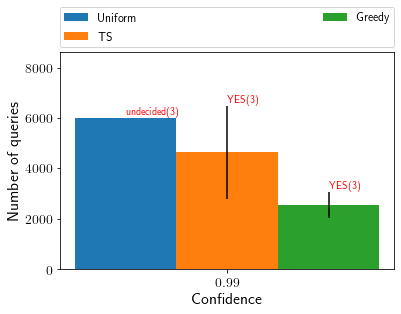

In [9]:
width = 0.1  # the width of the bars
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
bar_positions = np.arange(len(confidences))
for id1, alg in enumerate(algorithms):
    rects = ax.bar(bar_positions+(id1*width), means.loc[alg].values,
                   yerr=stds.loc[alg].values, width = width, label=alg)
    for id2,c in enumerate(confidences):
        Z = zip(decisions_counts[(alg,c)][0],decisions_counts[(alg,c)][1])
        l = len(decisions_set[(alg,c)])
        h = max_height
        ax.annotate(''.join(['%s(%d)\n'%(a[0],a[1]) for a in Z]),
                    xy=((bar_positions[id2]+(id1)*width),
                         means[(alg,c)]+ stds[(alg,c)] +(h*0.07*l)),
                    va='top', color='red', fontsize=10)
ax.set_xticks(bar_positions+(width*(len(algorithms)//2)))
ax.set_xticklabels([r'$%.2f$'%c for c in confidences])
ax.set_xlabel('Confidence', fontsize = 16)
ax.set_ylabel('Number of queries', fontsize = 16)
ax.set_ylim((0,(max_height + max_std)*1.1))
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',ncol=2,mode="expand", borderaxespad=0., fontsize=12)

Now we consider the measurement task (given a fixed confidence) for different query budgets. You can choose the exploration algorithms that you want to compare as the following. 

In [10]:
confidence = 0.95

In [11]:
budgets = [1000,5000,10000]
algorithms = ['Uniform','TS']
n_runs = 3

#uncomment the following lines to get the same figures presented in the paper
#budgets = [1000,5000,10000,15000]
#algorithms = ['Uniform','TS','TTTS','Greedy','PM']
#n_runs = 20

In [12]:
records = []
for ID in range(n_runs):
    for budget in budgets:
        for alg in algorithms:
            func = getattr(A, '%s_measurement'%alg)
            d = {'algorithm':alg, 'budget':budget, 'ID':ID, 
                 'DM_level':func(budget, confidence)}
            records.append(d)
            print(d)
R = pd.DataFrame.from_records(records)
D = R[['algorithm','budget','DM_level']]
means = D.groupby(['algorithm','budget'])['DM_level'].agg('mean')
stds = D.groupby(['algorithm','budget'])['DM_level'].agg('std')

{'algorithm': 'Uniform', 'budget': 1000, 'ID': 0, 'DM_level': 5.841255187988281e-06}
{'algorithm': 'TS', 'budget': 1000, 'ID': 0, 'DM_level': 0.00577545166015625}
{'algorithm': 'Uniform', 'budget': 5000, 'ID': 0, 'DM_level': 0.002552032470703125}
{'algorithm': 'TS', 'budget': 5000, 'ID': 0, 'DM_level': 0.01506805419921875}
{'algorithm': 'Uniform', 'budget': 10000, 'ID': 0, 'DM_level': 0.006011962890625}
{'algorithm': 'TS', 'budget': 10000, 'ID': 0, 'DM_level': 0.018070220947265625}
{'algorithm': 'Uniform', 'budget': 1000, 'ID': 1, 'DM_level': 5.841255187988281e-06}
{'algorithm': 'TS', 'budget': 1000, 'ID': 1, 'DM_level': 0.00272369384765625}
{'algorithm': 'Uniform', 'budget': 5000, 'ID': 1, 'DM_level': 0.0009517669677734375}
{'algorithm': 'TS', 'budget': 5000, 'ID': 1, 'DM_level': 0.0158843994140625}
{'algorithm': 'Uniform', 'budget': 10000, 'ID': 1, 'DM_level': 0.0045013427734375}
{'algorithm': 'TS', 'budget': 10000, 'ID': 1, 'DM_level': 0.016025543212890625}
{'algorithm': 'Uniform', 

In order to have a comparison point if the were no limit on the query budget, we compute the probabilistic data
minimization level using the population audit, i.e., using all the data points in the audit dataset.
Notice that this procedure is usually not feasible in practice since the number of system queries an auditor can ask
is limited.

In [13]:
A.population_audit()
population_level = A.DM_FWE_LB(confidence)

We plot the resulting data minimization levels as presented in Figure 2.

(-0.001, 0.023561477661132816)

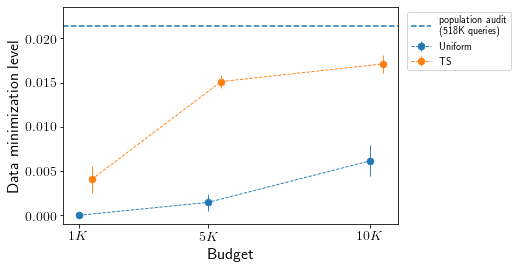

In [14]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
offset = 0
h_space = 400
for idx, alg in enumerate(algorithms):
    plt.errorbar(means[alg].index + offset, means[alg].values, stds[alg].values,
                 ls='--', lw=0.9 , marker='o', markersize=7,
                 fillstyle='full', markeredgewidth=0.5, label = alg)
    offset += h_space
ax.axhline(population_level, ls='--', label='population audit \n (%dK queries)'%(
                                        len(A.Y)*len(A.features)*
                                        max(map(len,list(A.domain.values())))//1000))
ax.set_xticks(budgets)
ax.set_xticklabels(['$%dK$'%(budget//1000) for budget in budgets])
ax.set_xlabel('Budget', fontsize = 16)
ax.set_ylabel('Data minimization level', fontsize = 16)
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', ncol=1,fontsize=10)
ax.set_ylim((-0.001,population_level*1.1))

Finally we consider the hypothetical scenario in which a prediction system has an input that is
not actually used by the prediction model, i.e., the system collects
excessive information from its users.
We obtain such system by embedding the Census/DT model in another prediction system that asks for
an additional attribute of the Census dataset but returns the output of
the embedded model. The source code for building this system is provided in 'census_model_redundant.py'.
Here we retrieve that model and run the decision auditing problem for 1% data minimization level.
The performance of different exploration algorithms are compared in a bar chart similar to Figure 3.

Retrieve the model:

In [21]:
dataset = 'Census'
model = 'DT'
n_features = 6
with open('Data/Models/%s-%s/%d_features-redundant'%(dataset, model, n_features), 'rb') as input:
    R = pickle.load(input)    
clf =  R['model']
data = R['data']    
A = DM.Auditor(clf, data, beta_priors)

Set the parameters:

In [16]:
DM_level = 0.01

confidences = [0.95]
algorithms = ['Uniform','TS','Greedy']
n_runs = 3
max_query = 6000

#uncomment the following lines to get the same figures presented in the paper
#confidences = [0.95,0.99]
#algorithms = ['Uniform','TS','TTTS','Greedy','PM']
#n_runs = 20
#max_query = 200000

Run auditing algorithms and plot the average number of queries used by each algorithm:

In [17]:
records = []
for ID in range(0,n_runs):
    for confidence in confidences:
        for alg in algorithms:
            func = getattr(A, '%s_decision'%alg)
            R = func(DM_level, confidence, max_query)
            d = {'algorithm':alg, 'confidence':confidence, 'ID':ID,
                 'decision':R[1], 'queries':R[2]}
            records.append(d)
            print(d)
R = pd.DataFrame.from_records(records)
decisions = R.groupby(['algorithm','confidence'])['decision'].apply(list)
decisions_set = decisions.apply(np.unique)
decisions_counts = decisions.apply(np.unique, return_counts=True)
D = R[['algorithm','confidence','queries']]
means = D.groupby(['algorithm','confidence'])['queries'].agg('mean')
stds = D.groupby(['algorithm','confidence'])['queries'].agg('std')
max_height = means.groupby('algorithm').max()[algorithms].max()
max_std = stds.groupby('algorithm').max()[algorithms].max()

{'algorithm': 'Uniform', 'confidence': 0.95, 'ID': 0, 'decision': 'undecided', 'queries': 6001}
{'algorithm': 'TS', 'confidence': 0.95, 'ID': 0, 'decision': 'NO', 'queries': 2188}
{'algorithm': 'Greedy', 'confidence': 0.95, 'ID': 0, 'decision': 'NO', 'queries': 1445}
{'algorithm': 'Uniform', 'confidence': 0.95, 'ID': 1, 'decision': 'undecided', 'queries': 6001}
{'algorithm': 'TS', 'confidence': 0.95, 'ID': 1, 'decision': 'NO', 'queries': 2227}
{'algorithm': 'Greedy', 'confidence': 0.95, 'ID': 1, 'decision': 'NO', 'queries': 1555}
{'algorithm': 'Uniform', 'confidence': 0.95, 'ID': 2, 'decision': 'undecided', 'queries': 6001}
{'algorithm': 'TS', 'confidence': 0.95, 'ID': 2, 'decision': 'NO', 'queries': 2212}
{'algorithm': 'Greedy', 'confidence': 0.95, 'ID': 2, 'decision': 'NO', 'queries': 1502}


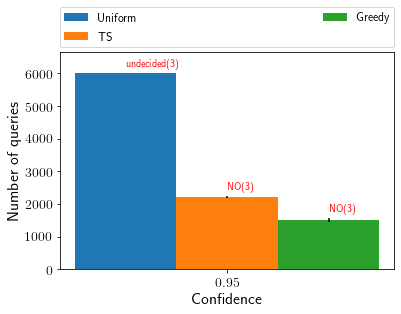

In [18]:
width = 0.1  # the width of the bars
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
bar_positions = np.arange(len(confidences))
for id1, alg in enumerate(algorithms):
    rects = ax.bar(bar_positions+(id1*width), means.loc[alg].values,
                   yerr=stds.loc[alg].values, width = width, label=alg)
    for id2,c in enumerate(confidences):
        Z = zip(decisions_counts[(alg,c)][0],decisions_counts[(alg,c)][1])
        l = len(decisions_set[(alg,c)])
        h = max_height
        ax.annotate(''.join(['%s(%d)\n'%(a[0],a[1]) for a in Z]),
                    xy=((bar_positions[id2]+(id1)*width),
                         means[(alg,c)]+ stds[(alg,c)] +(h*0.07*l)),
                    va='top', color='red', fontsize=10)
ax.set_xticks(bar_positions+(width*(len(algorithms)//2)))
ax.set_xticklabels([r'$%.2f$'%c for c in confidences])
ax.set_xlabel('Confidence', fontsize = 16)
ax.set_ylabel('Number of queries', fontsize = 16)
ax.set_ylim((0,(max_height + max_std)*1.1))
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',ncol=2,mode="expand", borderaxespad=0., fontsize=12)